In [1]:
%load_ext autoreload
%autoreload 2
import cd_rom
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

-------------------------------------------------------------------
torch_ACA not installed, adaptive time stepping won't be supported
If you need it, download the library here :
             https://github.com/juntang-zhuang/torch_ACA
-------------------------------------------------------------------


torch.Size([10001, 1])


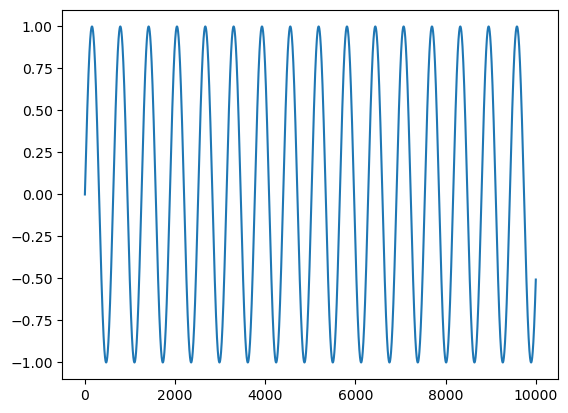

In [2]:
tmax = 100
dt = 1e-2
time = np.linspace(0,tmax,int(tmax/dt)+1)
np_data = np.sin(time)#+np.sin(1.27*time)
data = torch.tensor(np_data).cuda().reshape(-1,1)
print(data.shape)
plt.plot(np_data)

In [7]:
class NDDE(nn.Module):
    
    def __init__(self,dim,delays,width=64):
        super().__init__()
        self.in_dim = dim * (1+len(delays))
        self.delays = delays
        self.model = nn.Sequential(nn.Linear(self.in_dim,width),nn.ReLU(),
                                   nn.Linear(width,width),nn.ReLU(),
                                   nn.Linear(width,width),nn.ReLU(),
                                   nn.Linear(width,width),nn.ReLU(),
                                   nn.Linear(width,dim))
        
    def forward(self,t,z,*delays):
        
        inp = torch.cat([z,*delays],dim=-1)
        return self.model(inp)

In [24]:
def get_batch( delays, batch_size = 256, length=100):
    
    ix = np.random.choice(data.shape[0]-max(delays)-length,size=batch_size)
    history_batch = torch.stack([data[i:i+max(delays)+1] for i in ix])#.permute(1,0,2)
    interpolator = cd_rom.interpolators.TorchLinearInterpolator(
                            history_batch,
                            time=-dt*torch.arange(max(delays)+1).cuda().flip(0))
    batch = torch.stack([data[i+max(delays):i+max(delays)+length] for i in ix])
    
    return interpolator, batch

In [38]:
delay_pts

[157]

In [39]:
length = 200
integration_options = {
                'nSteps':length-1,
                'dt':dt,
                't0':0,
                'eval_idx':np.arange(length)
            }
delay_pts = [int((2*np.pi/4)/dt)]
model = NDDE(1,[d*dt for d in delay_pts],width=64).to(data.dtype).cuda()
lossfunc = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
losses = []
lens = []

In [40]:
history(0).shape,traj.shape

(torch.Size([256, 1]), torch.Size([256, 500, 1]))

In [41]:
history, traj = get_batch(delay_pts,length= length)
model(0,traj[:,-1],*[history(0)]).shape

torch.Size([256, 1])

In [42]:
for i in range(100000):
    opt.zero_grad()
    history, traj = get_batch(delay_pts,length= length)
    ret = cd_rom.NDDE_adjoint.nddesolve_adjoint(history,model,integration_options)
    #loss = torch.mean(torch.sum((ret.permute(1,0,2)-traj)**4,axis=-1)**0.25)
    loss = lossfunc(ret.permute(1,0,2),traj)
    loss.backward()
    opt.step()
    print('Epoch : {:4d}, length : {:4d}, Loss : {:.3e}'.format(i,length,loss.item()))
    losses.append(loss.item())
    lens.append(length)
    if losses[-1]<1e-2:
        length+=1
        integration_options = {
                'nSteps':length-1,
                'dt':dt,
                't0':0,
                'eval_idx':np.arange(length)
            }
    if length > 1000 : break

Epoch :    0, length :  200, Loss : 5.302e-01
Epoch :    1, length :  200, Loss : 5.320e-01
Epoch :    2, length :  200, Loss : 5.089e-01
Epoch :    3, length :  200, Loss : 5.509e-01
Epoch :    4, length :  200, Loss : 5.787e-01
Epoch :    5, length :  200, Loss : 5.501e-01
Epoch :    6, length :  200, Loss : 5.300e-01
Epoch :    7, length :  200, Loss : 4.954e-01
Epoch :    8, length :  200, Loss : 5.549e-01
Epoch :    9, length :  200, Loss : 5.275e-01
Epoch :   10, length :  200, Loss : 5.356e-01
Epoch :   11, length :  200, Loss : 5.222e-01
Epoch :   12, length :  200, Loss : 5.421e-01
Epoch :   13, length :  200, Loss : 5.726e-01
Epoch :   14, length :  200, Loss : 5.228e-01
Epoch :   15, length :  200, Loss : 5.462e-01
Epoch :   16, length :  200, Loss : 5.414e-01
Epoch :   17, length :  200, Loss : 5.476e-01
Epoch :   18, length :  200, Loss : 5.562e-01
Epoch :   19, length :  200, Loss : 5.092e-01
Epoch :   20, length :  200, Loss : 5.695e-01
Epoch :   21, length :  200, Loss 

KeyboardInterrupt: 

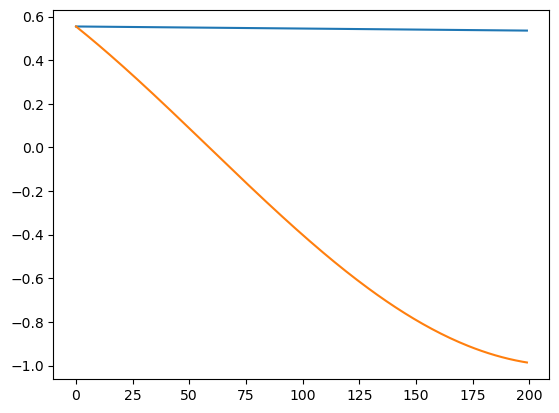

In [43]:
plt.plot(ret[:,0].detach().cpu().numpy())
plt.plot(traj[0,:].detach().cpu())

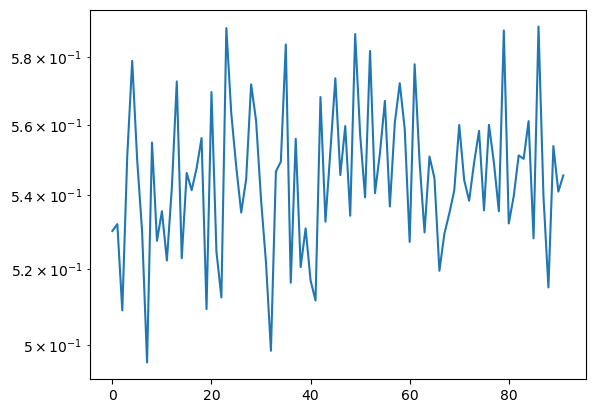

In [44]:
plt.semilogy(losses)

In [51]:
history, traj = get_batch(delay_pts,length= 1000)
inference_options = {
            'nSteps':1000,
            'dt':dt,
            't0':0,
            'eval_idx':np.arange(1000)
        }
ret = cd_rom.NDDE_adjoint.nddesolve_adjoint(history,model,inference_options)

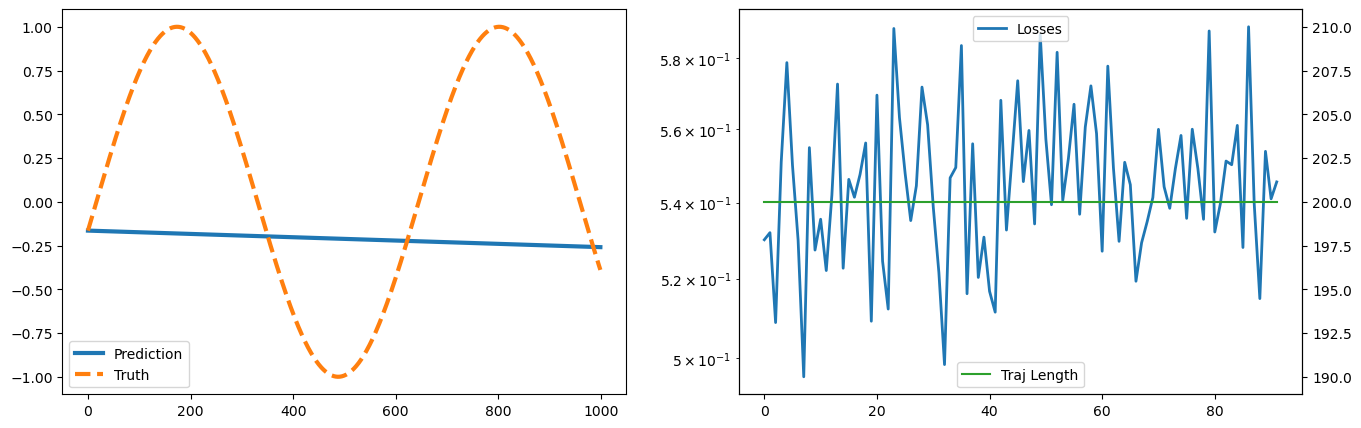

In [52]:
fig, axs = plt.subplots(ncols=2,figsize=(16,5))
plt.sca(axs[0])
plt.plot(ret[:,0].detach().cpu().numpy(),label='Prediction',lw=3)
plt.plot(traj[0,:].detach().cpu(),'--',label='Truth',lw=3)
plt.legend()
plt.sca(axs[1])
plt.semilogy(losses,lw=2,label='Losses')
plt.legend(loc='upper center')
ax = axs[1].twinx()
ax.plot(lens,label='Traj Length',color='tab:green')
plt.legend(loc='lower center')


In [68]:
%timeit ret = cd_rom.NDDE_adjoint.nddesolve_adjoint(history,model,inference_options); \
        loss = torch.linalg.norm(ret); loss.backward()

670 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
history, traj = get_batch(delay_pts,75)

In [9]:
interpolator = cd_rom.interpolators.TorchLinearInterpolator(
                            traj.permute(1,0,2),
                            time=dt*torch.arange(traj.shape[1]).cuda())

In [18]:
traj.shape

torch.Size([75, 100, 1])

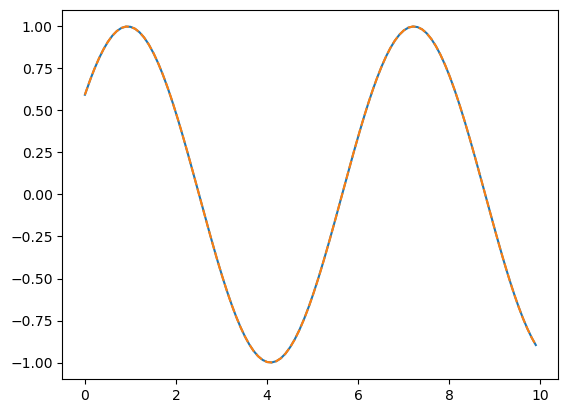

In [22]:
spl_time = np.linspace(0,(traj.shape[1]-1)*dt,1000)
c = np.random.choice(traj.shape[0])
interpolated = []
for t in spl_time:
    interpolated.append(interpolator(t))
interpolated = torch.stack(interpolated)
plt.plot(spl_time,interpolated[:,c].detach().cpu())
plt.plot(dt*np.arange(traj.shape[1]),traj[c,:].detach().cpu(),'--')